In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('camera_cal/calibration5.jpg')

In [2]:
import glob

def cc():
    # Camera Calibration
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] #3D
    imgpoints = [] #2D

    images = glob.glob('camera_cal/calibration*.jpg')
        
    for path in images:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    return objpoints, imgpoints

objpoints, imgpoints = cc()

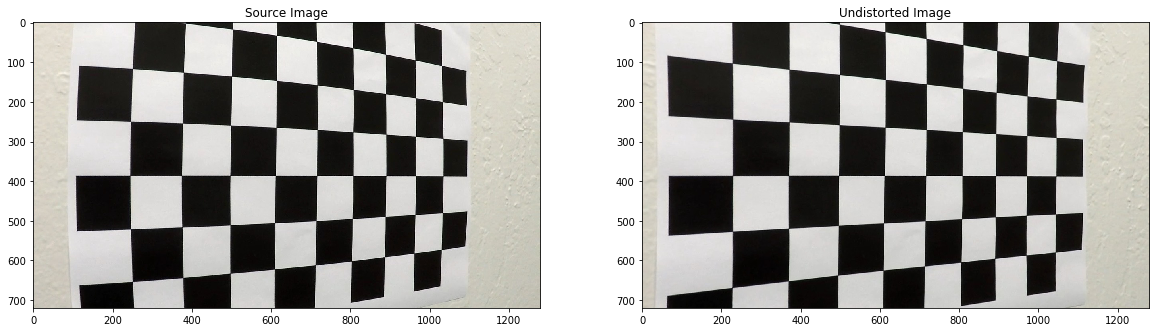

In [15]:
def undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


dst_im = undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title('Source Image')
ax1.imshow(image)
ax2.set_title('Undistorted Image')
ax2.imshow(dst_im)
plt.show()


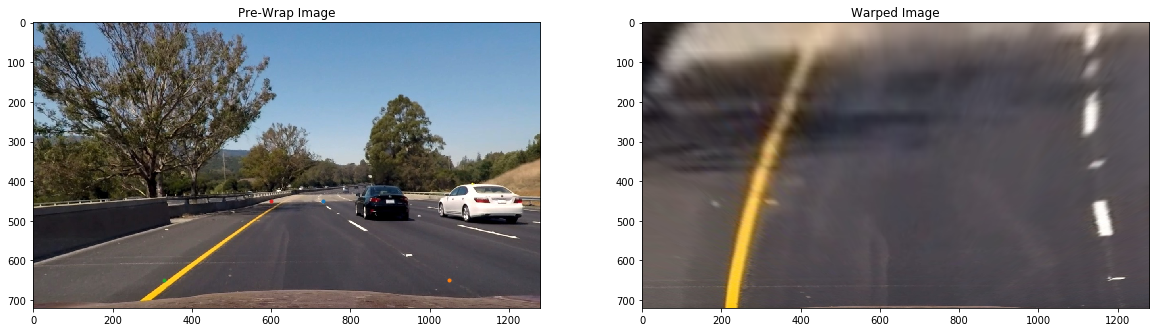

In [4]:
def warp(img, unwrap=False):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[730,450], # right top
         [1050,650], # right bottom
         [330,650], # left bottom
         [600,450]]) #left top
    
    dst = np.float32(
        [[1200,0], #right top
         [1200,700], # right bottom
         [200,700], # left bottom
         [200,0]]) 
    if unwrap:
        return cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src,dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags= cv2.INTER_LINEAR)
    
    return warped

warped_im = warp(dst_im)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title('Pre-Wrap Image')
ax1.imshow(dst_im)
ax1.plot(730,450,'.')
ax1.plot(1050,650,'.')
ax1.plot(330,650,'.')
ax1.plot(600,450,'.')
ax2.set_title('Warped Image')
ax2.imshow(warped_im)
plt.show()


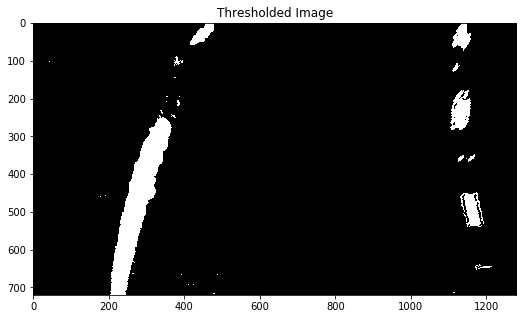

In [12]:
def img_preprocess(img):
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]

    # Threshold color channel
    s_min = 170
    s_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_min) & (s_channel <= s_max)] = 1

    b_min = 150
    b_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_min) & (b_channel <= b_max)] = 1

    l_min = 200
    l_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_min) & (l_channel <= l_max)] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 40
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
        
    return combined_binary



f, ax1 = plt.subplots(1,1,figsize=(20,5))
ax1.set_title('Thresholded Image')
ax1.imshow(img_preprocess(warped_im), cmap='gray')
plt.show()

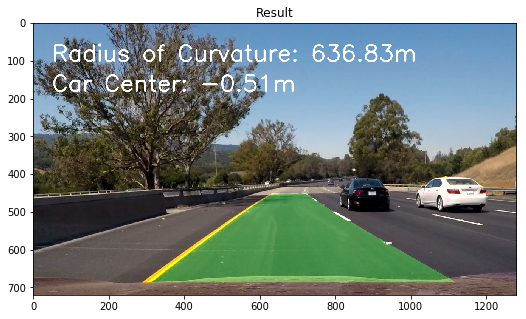

In [13]:
def lane_line(img, image):
    binary_warped = img
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = warp(img, True)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature: {:.2f}m'.format((left_curverad + right_curverad)/2)
    cv2.putText(result,text,(50, 100), font, 2, (255,255,255), 4, cv2.LINE_AA)
    
    # Assuming center of camera is the car's center
    car_center = img.shape[1]/2
    
    # Center between lane lines
    center_lane = np.mean(left_fitx+right_fitx)/2
    
    # Compute the diffrenece between car center and lane lines center
    center = (car_center - center_lane)*xm_per_pix
    text = 'Car Center: {:.2f}m'.format(center)
    cv2.putText(result,text,(50, 180), font, 2, (255,255,255), 4, cv2.LINE_AA)
    
    return result

f, ax1 = plt.subplots(1,1,figsize=(20,5))
ax1.set_title('Result')
ax1.imshow(lane_line(img_preprocess(warped_im), image))
plt.show()

In [7]:
def pipeline(img):
    dst_im = undistort(img, objpoints, imgpoints)
    warpped = warp(dst_im)
    preprocessed = img_preprocess(warpped)
    result = lane_line(preprocessed, img)
    return result

In [8]:
import io
import base64
from IPython.display import HTML

def watch_video(video_file):
    video = io.open(video_file, 'r+b').read()
    encoded = base64.b64encode(video)

    html = HTML(data='''<video alt="Advance Lane Line Finding" controls autoplay width="550">
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii')))
    return html

In [ ]:
from moviepy.editor import VideoFileClip

def alf(path):
    output = path + '_result.mp4'
    clip = VideoFileClip(path+'.mp4')
    white_clip = clip.fl_image(pipeline)
    white_clip.write_videofile(output, audio=False)
    return output
    

watch_video(alf('project_video'))